<a href="https://colab.research.google.com/github/ChaoWANG0511/Akabot1/blob/jinyu/musdb_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install, import各包

In [0]:
!pip install pandas==1.0.3
!apt install -y libsndfile1 ffmpeg
!pip install musdb
!pip install museval
!pip install -q scikit_posthocs
!pip install librosa

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.1).
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
     |████████████████████████████████| 512kB 5.0MB/s 
     |████████████████████████████████| 92kB 3.5MB/s 
  Created wheel for simplejson: filename=simplejson-3.17.0-cp36-cp36m-linux_x86_64.whl size=114203 sha256=4c6c17e4777055ce5bf2204e36aa870bd043527476f6f346b835ca62c50d9369
  Stored in directory: /root/.cache/pip/wheels/86/c0/83/dcd0339abb2640544bb8e0938aab2d069cef55e5647ce6e097
Successfully built simplejson


In [0]:
!pip install scikit_posthocs

In [0]:
from IPython.display import Audio, display
import urllib.request
import numpy as np
import scipy.stats
import seaborn as sns
import pandas as pd
from urllib.request import urlopen
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.transforms import BlendedGenericTransform
import scikit_posthocs as sp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 频谱 数据预处理

[batch, channel, time, freaquency]

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from math import ceil

def chop(spectrogram, wanted_time, ratio_overlap):
  # 条件： wanted_time * ratio_overlap 是整数
  (I, F, T) = spectrogram.shape
  K = int(ceil((T / wanted_time - ratio_overlap)/(1 - ratio_overlap)))  # ceil取上,要分成多少块
  expanded_T = int(wanted_time + wanted_time * (1 - ratio_overlap) * (K - 1)) # 扩展后的time维度
  newSpectrogram = np.zeros((I, F, expanded_T))   # 右：多一些0，至能被girdsize整除
  newSpectrogram[:, :, :T] = spectrogram
  slices = np.empty((0, I, F, wanted_time), float)
  for k in range(0, K):   # 列
    s = newSpectrogram[:, :, round(k * wanted_time * (1-ratio_overlap)):round(k * wanted_time * (1-ratio_overlap) + wanted_time)] # 切为很多小块
    s = np.expand_dims(s, axis=0)
    slices = np.append(slices, s, axis=0)
  slices = np.transpose(slices, (0, 1, 3, 2)) # 想要[batch, channel, time, freaquency] 
  return slices
  
#x = np.ones((2, 2049, 295))
#x = chop(x, 60, 0.3)

In [0]:
from scipy.signal import stft, istft
import musdb
mus = musdb.DB(download=True, subsets='train')

Done!


In [0]:
def dataset(nbmus, time=240, ratio_overlap=0.5):
  eps = np.finfo(np.float).eps  # small epsilon to avoid dividing by zero

  X = np.empty((0, 2, time, 2049), float)
  M = {'vocals': np.empty((0, 2, time, 2049), float),
      'drums': np.empty((0, 2, time, 2049), float),
      'bass': np.empty((0, 2, time, 2049), float),
      'other': np.empty((0, 2, time, 2049), float)} # [batch, channel, time, freaquency] 

  for track in nbmus:
    print(track.name)
    x = np.abs(stft(track.audio.T, nperseg=4096, noverlap=3072)[-1])   # shape: (nb_channels=channel, nb_features=freq, nb_frames=time)
    xs = chop(x,time,ratio_overlap)
    X = np.append(X, xs, axis=0)

    P = {} # sources spectrograms
    # compute model as the sum of spectrograms 分母
    model = eps
    for name, source in track.sources.items():  # 遍历所有声部，求mask中的分母
      # compute spectrogram of target source:
      P[name] = np.abs(stft(source.audio.T, nperseg=4096, noverlap=3072)[-1])
      model += P[name]

    for name, source in track.sources.items(): # 遍历所有声部，用mask分离出各个声部
      # compute soft mask as the ratio between source spectrogram and total
      mask = P[name] / model
      masks = chop(mask,time,ratio_overlap)
      M[name] = np.append(M[name], masks, axis=0)

  return X, M

X, M = dataset(mus) # [:7]

A Classic Education - NightOwl
ANiMAL - Clinic A
ANiMAL - Easy Tiger
ANiMAL - Rockshow
Actions - Devil's Words
Actions - One Minute Smile
Actions - South Of The Water
Aimee Norwich - Child
Alexander Ross - Goodbye Bolero
Alexander Ross - Velvet Curtain
Angela Thomas Wade - Milk Cow Blues
Atlantis Bound - It Was My Fault For Waiting
Auctioneer - Our Future Faces
AvaLuna - Waterduct
BigTroubles - Phantom
Bill Chudziak - Children Of No-one
Black Bloc - If You Want Success
Celestial Shore - Die For Us
Chris Durban - Celebrate
Clara Berry And Wooldog - Air Traffic
Clara Berry And Wooldog - Stella
Clara Berry And Wooldog - Waltz For My Victims
Cnoc An Tursa - Bannockburn
Creepoid - OldTree
Dark Ride - Burning Bridges
Dreamers Of The Ghetto - Heavy Love
Drumtracks - Ghost Bitch
Faces On Film - Waiting For Ga
Fergessen - Back From The Start
Fergessen - Nos Palpitants
Fergessen - The Wind
Flags - 54
Giselle - Moss
Grants - PunchDrunk
Helado Negro - Mitad Del Mundo
Hezekiah Jones - Borrowed Hear

In [0]:
print(X.shape, M['vocals'].shape)

(188, 2, 240, 2049) (188, 2, 240, 2049)


# 模型

## import

In [0]:
import tensorflow as tf
assert tf.__version__.startswith('2')
tf.random.set_seed(1234)

from tensorflow.keras.layers import Conv2D, concatenate

# !pip install tensorflow-datasets==1.2.0
# import tensorflow_datasets as tfds

import os
import re
import numpy as np

import matplotlib.pyplot as plt

## for test

In [0]:
d_model = (2, 240, 2049) # (channel, time, freq)
inputs = tf.keras.Input(shape=d_model, name="inputs")
embedding = tf.keras.layers.Conv2D(filters=2, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_first')(inputs) 
print(embedding.shape)

(None, 2, 240, 2049)


## scaled dot-product attention



In [0]:
def scaled_dot_product_attention(query, key, value):
  # query = tf.squeeze(query, axis=-1)
  # key = tf.squeeze(key, axis=-1)
  # value = tf.squeeze(value, axis=-1)

  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)  # Q * K^T  矩阵乘法

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)   # cast: 转换数据格式, dk: number of feature maps 最后一维freq维数！
  logits = matmul_qk / tf.math.sqrt(depth)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)   # 沿最后一维softmax！

  output = tf.matmul(attention_weights, value)  # softmax * V

  # output = tf.expand_dims(output, -1)

  return output

# a = scaled_dot_product_attention(embedding, embedding, embedding)
# a.shape  # TensorShape([None, 3, 240, 2049])

## multi-head attention



In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_channel=2, num_heads=3, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads  
    self.d_channel = d_channel  

    #assert d_model % self.num_heads == 0

    #self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Conv2D(filters=d_channel*num_heads, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first')
    self.key_dense = tf.keras.layers.Conv2D(filters=d_channel*num_heads, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first')
    self.value_dense = tf.keras.layers.Conv2D(filters=d_channel*num_heads, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first')

    self.dense = tf.keras.layers.Conv2D(filters=d_channel, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_first')  # 1


  def call(self, inputs):
    query, key, value = inputs['query'], inputs['key'], inputs['value']
    batch_size = tf.shape(query)[0]

    querys = self.query_dense(query)
    keys = self.key_dense(key)
    values = self.value_dense(value)

    # 切成每个头
    i = 0
    query_i = querys[:, self.d_channel*i:self.d_channel*(i+1), :,:]
    key_i = keys[:, self.d_channel*i:self.d_channel*(i+1), :,:]
    value_i = values[:, self.d_channel*i:self.d_channel*(i+1), :,:]

    concat_attention = scaled_dot_product_attention(query_i, key_i, value_i)
    for i in range(1,self.num_heads):
      # split heads
      query_i = querys[:, self.d_channel*i:self.d_channel*(i+1), :,:]
      key_i = keys[:, self.d_channel*i:self.d_channel*(i+1), :,:]
      value_i = values[:, self.d_channel*i:self.d_channel*(i+1), :,:]
      # scaled dot-product attention
      scaled_attention_i = scaled_dot_product_attention(query_i, key_i, value_i)

      # concatenation of heads
      concat_attention = tf.concat([concat_attention, scaled_attention_i], 1)
      # conca = concatenate([scaled_attention1, scaled_attention2, scaled_attention3, scaled_attention4, scaled_attention5], name='merge14', axis=-1)

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs



## sliced attention

In [0]:
def split_slices(input_qkv, batch=2, time_slices=12):
  channel = input_qkv.shape[1]
  time = input_qkv.shape[2]
  freq = input_qkv.shape[3] 
  assert time % time_slices == 0
  time_dslice = time // time_slices
  slices = tf.reshape(input_qkv, shape=(batch, channel, time_slices, time_dslice, freq))  
  return slices    


def slicedAttention(d_channels=2, name="slicedAttention"):
  inputs = tf.keras.Input(shape=(2, 240, 2049), name="inputs")

  query = tf.keras.layers.Conv2D(filters=d_channels, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first')(inputs) #1*1的CNN层用3次：分别得到query Q, key K, value V
  key = tf.keras.layers.Conv2D(filters=d_channels, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first')(inputs)
  value = tf.keras.layers.Conv2D(filters=d_channels, kernel_size=(1,1), strides=(1,1), padding='same', data_format='channels_first')(inputs)  # (None, 120, 1025, 1) 

  # split slices
  querys = split_slices(query)  # (64, 8, 15, 1025, 1)
  keys = split_slices(key)
  values = split_slices(value) 

  # multi-head attention for each slice
  query = querys[:,:,0,:,:]          # (64, 15, 1025, 1)
  key = keys[:,:,0,:,:]
  value = values[:,:,0,:,:]
  multi_head_attention = MultiHeadAttention(d_channel=2, num_heads=3, name="multi_head_attention")(inputs={
        'query': query, 'key': key, 'value': value})

  time_slices = int(querys.shape[2])
  for i in range(1,time_slices):
    query = querys[:,:,i,:,:]
    key = keys[:,:,i,:,:]
    value = values[:,:,i,:,:]
    multi_head_attention_i = MultiHeadAttention(
    d_channel=2, num_heads=3, name="multi_head_attention_{}".format(i))({
          'query': query,
          'key': key,
          'value': value,
      })
    multi_head_attention = tf.concat([multi_head_attention, multi_head_attention_i], -2) 

  return tf.keras.Model(inputs=inputs, outputs=multi_head_attention, name=name)
 
a = slicedAttention(d_channels=2)(embedding)
print(a.shape)

(2, 2, 240, 2049)


## encoder layer

In [0]:
def encoder_layer(units=10, d_model=(2, 240, 2049), dropout=0.1, name="encoder_layer"):  
  inputs = tf.keras.Input(shape=d_model, name="inputs")
  embedding = tf.keras.layers.Conv2D(filters=2, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_first')(inputs)  

  attention = slicedAttention(d_channels=2)(embedding)

  # attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  normed_attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(embedding + attention) 

  outputs1 = tf.keras.layers.Conv2D(filters=units, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', data_format='channels_first', name='conv1')(normed_attention)
  outputs1 = tf.keras.layers.Dropout(rate=dropout)(outputs1)
  outputs2 = tf.keras.layers.Conv2D(filters=2, kernel_size=(3,3), strides=(1,1), activation='relu', padding='same', data_format='channels_first', name='conv2')(outputs1)
  outputs2 = tf.keras.layers.Dropout(rate=dropout)(outputs2)
  outputsf = tf.keras.layers.LayerNormalization(epsilon=1e-6, name="outputs")(embedding + attention + outputs2) 

  return tf.keras.Model(inputs=inputs, outputs=outputsf, name=name)

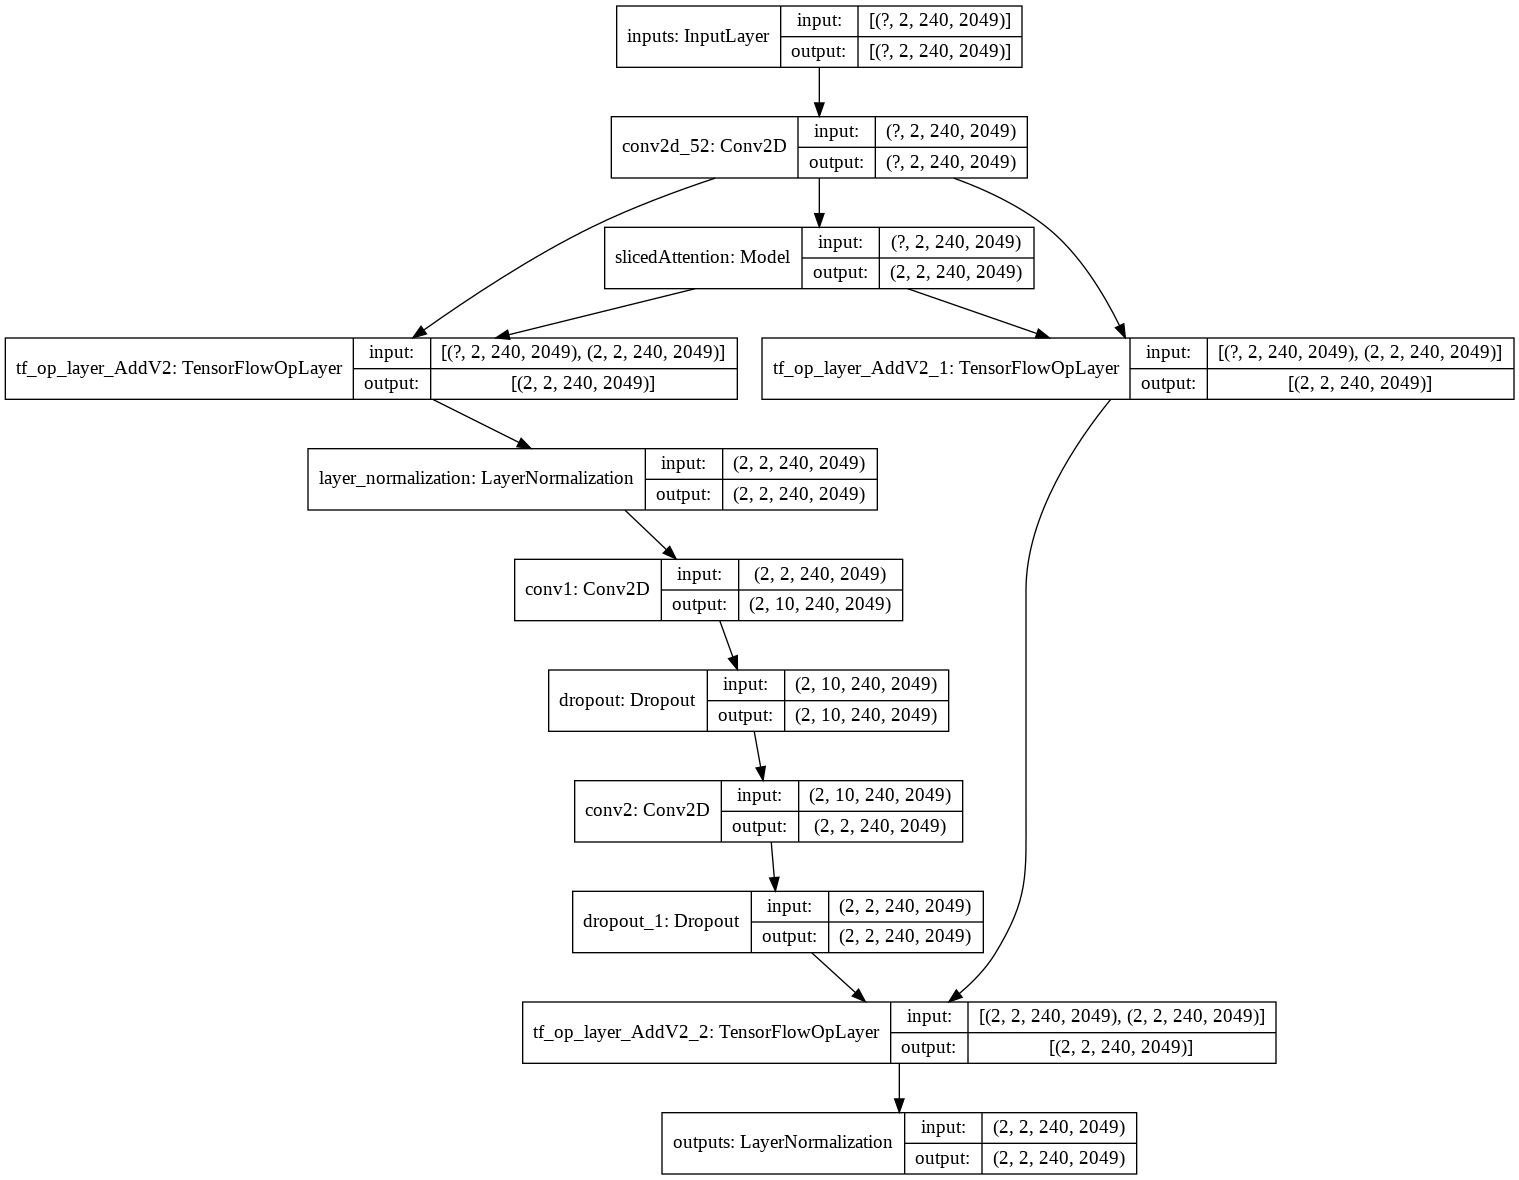

In [0]:
sample_encoder_layer = encoder_layer(units=10, d_model=(2, 240, 2049), dropout=0.1, name="encoder_layer")

tf.keras.utils.plot_model(sample_encoder_layer, to_file='encoder_layer.png', show_shapes=True)

# 训练

## 初始化模型

In [0]:
tf.keras.backend.clear_session()

# Hyper-parameters
D_MODEL = (2, 240, 2049)
UNITS = 10
DROPOUT = 0.1
model = encoder_layer(units=UNITS, d_model=D_MODEL, dropout=DROPOUT, name="encoder_layer")

## 学习率

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

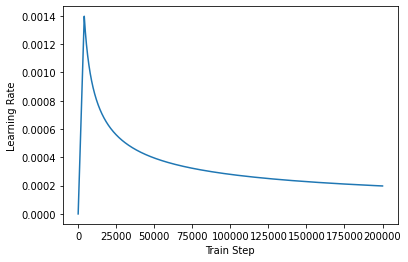

In [0]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## 编译

In [0]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(0.0001, beta_1=0.9, beta_2=0.98, epsilon=1e-9) #learning_rate

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())  # , metrics=[accuracy]
from tensorflow.keras.metrics import Accuracy
model.compile(loss='mean_squared_error', optimizer='adam', metrics=[Accuracy()])

## 训练

In [0]:
print(X.shape, M['vocals'].shape)

(188, 2, 240, 2049) (188, 2, 240, 2049)


In [0]:
EPOCHS = 20



# tf.config.experimental_run_functions_eagerly(True)
#model.fit(dataset, epochs=EPOCHS)
history = model.fit(X[:20,:,:,:], M['vocals'][:20,:,:,:], batch_size=2, epochs=EPOCHS)

Epoch 1/20
10/10 [==============================] - 1s 57ms/step - loss: 1.0415 - accuracy: 0.0121
Epoch 2/20
10/10 [==============================] - 1s 57ms/step - loss: 0.9710 - accuracy: 0.0000e+00
Epoch 3/20
10/10 [==============================] - 1s 57ms/step - loss: 0.9265 - accuracy: 0.0000e+00
Epoch 4/20
10/10 [==============================] - 1s 57ms/step - loss: 0.8952 - accuracy: 0.0000e+00
Epoch 5/20
10/10 [==============================] - 1s 57ms/step - loss: 0.8580 - accuracy: 0.0000e+00
Epoch 6/20
10/10 [==============================] - 1s 57ms/step - loss: 0.8057 - accuracy: 5.0838e-08
Epoch 7/20
10/10 [==============================] - 1s 57ms/step - loss: 0.7224 - accuracy: 2.0335e-07
Epoch 8/20
10/10 [==============================] - 1s 57ms/step - loss: 0.6415 - accuracy: 0.0000e+00
Epoch 9/20
10/10 [==============================] - 1s 57ms/step - loss: 0.5670 - accuracy: 5.0838e-08
Epoch 10/20
10/10 [==============================] - 1s 57ms/step - loss: 0.4

# 预测

In [0]:
track = [mus[-1]]

X, M = dataset(track)

X_origin = stft(track[0].audio.T, nperseg=4096, noverlap=3072)[-1]

print(X.shape, len(M), M['vocals'].shape, X_origin.shape)

Young Griffo - Pennies
(2, 2, 240, 2049) 4 (2, 2, 240, 2049) (2, 2049, 294)


In [0]:
M_predict = model.predict(X)
print(M_predict.shape)

(2, 2, 240, 2049)


In [0]:
MM_predict = {'vocals': M_predict,
      'drums': M_predict,
      'bass': M_predict,
      'other':M_predict}

In [0]:
def ichop(X_origin, M, time_scale=240, ratio_overlap=0.5): # 输入只一首歌
  channel, frequency, time = X_origin.shape
  newM = {'vocals': np.empty((channel, frequency, time+time_scale), float),
      'drums': np.empty((channel, frequency, time+time_scale), float),
      'bass': np.empty((channel, frequency, time+time_scale), float),
      'other': np.empty((channel, frequency, time+time_scale), float)} # [channel, frequency, time] 
  for name, source in M.items():
    for i in range(source.shape[0]): # 遍历batch
      toInput = np.transpose(source[i,:,:,:], (0, 2, 1))  # (2, 2049, 240)
      if i == 0:
        newM[name][:,:, i:i + time_scale] = toInput
      else:
        
        newM[name][:,:, int(i * time_scale * (1 - ratio_overlap)):int((i * time_scale * (1 - ratio_overlap) + time_scale * ratio_overlap))] = np.true_divide(
              np.add(
              newM[name][:,:, int(i * time_scale * (1 - ratio_overlap)):int(i * time_scale * (1 - ratio_overlap) + time_scale * ratio_overlap)],toInput[:,:, :int(time_scale * ratio_overlap)]), 
              2)
        newM[name][:,:, int(i * time_scale * (1 - ratio_overlap) + time_scale * ratio_overlap):int(
              i * time_scale * (1 - ratio_overlap) + time_scale)] = toInput[:,:,-int(time_scale * (1 - ratio_overlap)):]
    newM[name] = newM[name][:channel, :frequency, :time]
  return newM



newM = ichop(X_origin, M)
print(newM['vocals'].shape)

(2, 2049, 294)


In [0]:
def estimateSpectro(X_origin, newM):
  
  # small epsilon to avoid dividing by zero
  eps = np.finfo(np.float).eps
  # compute model as the sum of spectrograms
  model = eps

  for name, source in newM.items():  # 遍历所有声部，求mask中的分母
    model += newM[name]


  # now performs separation
  estimates = {}
  for name, source in newM.items(): # 遍历所有声部，用mask分离出各个声部
    # compute soft mask as the ratio between source spectrogram and total
    Mask = newM[name] / model

    # multiply the mix by the mask
    Yj = Mask * X_origin

    # invert to time domain
    target_estimate = istft(Yj, nperseg=4096, noverlap=3072)[1].T

    # set this as the source estimate
    estimates[name] = target_estimate

  return estimates

estimates = estimateSpectro(X_origin, newM)

from IPython.display import Audio, display

for target, estimate in estimates.items():
  display(Audio(estimate.T, rate=track[0].rate))

In [0]:
display(Audio(track[0].audio.T, rate=track[0].rate))

# 评估

分离出的所有声部后，即可用museval包评估。

In [0]:
import museval

track_scores = museval.eval_mus_track(track[0], estimates)
print(track_scores)

vocals          ==> SDR:   1.455  SIR:  -3.902  ISR:   2.474  SAR:  28.483  
drums           ==> SDR:   0.663  SIR:  -6.559  ISR:   2.542  SAR:  28.483  
bass            ==> SDR:   1.932  SIR:  -1.093  ISR:   2.545  SAR:  28.483  
other           ==> SDR:   0.618  SIR:  -6.686  ISR:   2.552  SAR:  28.483  



In [0]:
track_scores.df  # pandas.Dataframe版结果

,time,target,metric,score,track
0,0.0,vocals,SDR,1.18053,Young Griffo - Pennies
1,1.0,vocals,SDR,0.62617,Young Griffo - Pennies
2,2.0,vocals,SDR,1.33940,Young Griffo - Pennies
3,3.0,vocals,SDR,1.79495,Young Griffo - Pennies
4,4.0,vocals,SDR,1.60830,Young Griffo - Pennies
...,...,...,...,...,...
91,1.0,other,SIR,-6.91594,Young Griffo - Pennies
92,2.0,other,SIR,-8.15449,Young Griffo - Pennies
93,3.0,other,SIR,-5.83766,Young Griffo - Pennies
94,4.0,other,SIR,-5.83777,Young Griffo - Pennies


### 和其它方法结果比较

把自己的方法在所有歌上得到的平均评估结果加入到SiSEC中，下载其它方法结果，和其它方法结果比较。

In [0]:
mymethod = museval.aggregate.EvalStore(frames_agg='median', tracks_agg='median')
mymethod.add_track(track_scores)
print(mymethod)

Aggrated Scores (median over frames, median over tracks)
vocals          ==> SDR:   1.455  SIR:  -3.902  ISR:   2.474  SAR:  28.483  
drums           ==> SDR:   0.663  SIR:  -6.559  ISR:   2.542  SAR:  28.483  
bass            ==> SDR:   1.932  SIR:  -1.093  ISR:   2.545  SAR:  28.483  
other           ==> SDR:   0.618  SIR:  -6.686  ISR:   2.552  SAR:  28.483  



下载其它方法结果

In [0]:
# Open URL
methods = museval.aggregate.MethodStore()
methods.add_sisec18()
methods.add_evalstore(mymethod, name='Oracle')
print(methods.df)

Done!
         time  target  ...                                      track  method
0         0.0  vocals  ...  Signe Jakobsen - What Have You Done To Me    2DFT
1         1.0  vocals  ...  Signe Jakobsen - What Have You Done To Me    2DFT
2         2.0  vocals  ...  Signe Jakobsen - What Have You Done To Me    2DFT
3         3.0  vocals  ...  Signe Jakobsen - What Have You Done To Me    2DFT
4         4.0  vocals  ...  Signe Jakobsen - What Have You Done To Me    2DFT
...       ...     ...  ...                                        ...     ...
6019095   1.0   other  ...                     Young Griffo - Pennies  Oracle
6019096   2.0   other  ...                     Young Griffo - Pennies  Oracle
6019097   3.0   other  ...                     Young Griffo - Pennies  Oracle
6019098   4.0   other  ...                     Young Griffo - Pennies  Oracle
6019099   5.0   other  ...                     Young Griffo - Pennies  Oracle

[6019100 rows x 6 columns]


Display scores

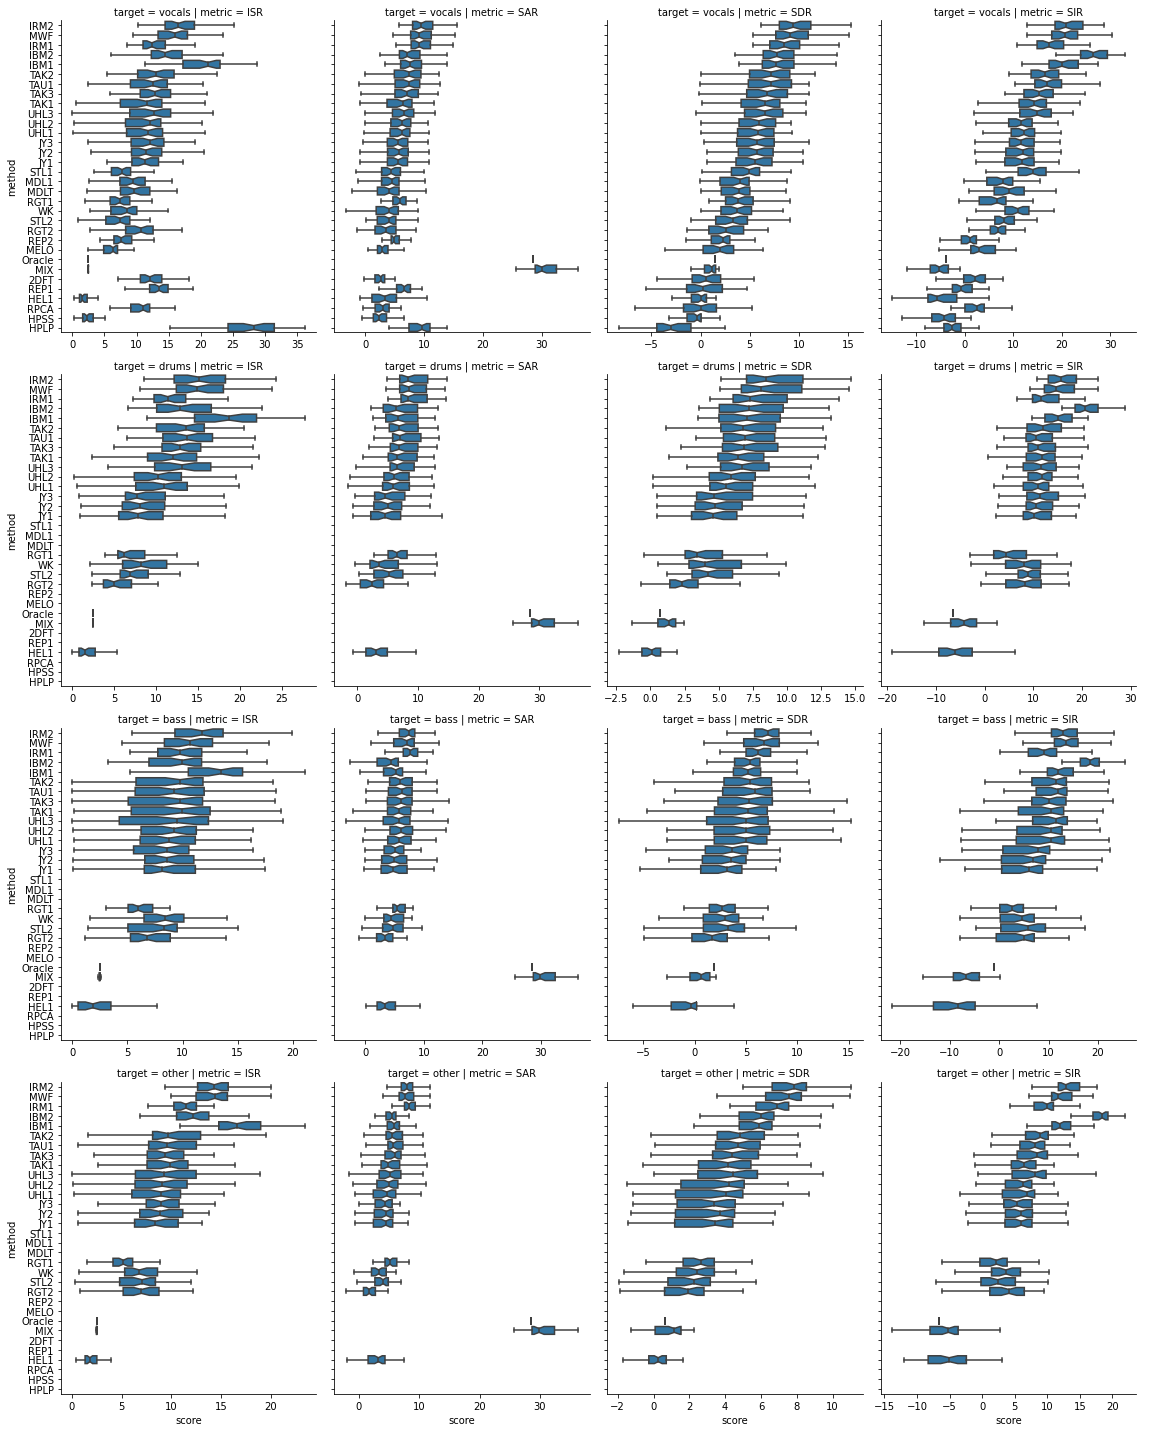

In [0]:
# important!
df = methods.df.groupby(
    ['method', 'track', 'target', 'metric']
).median().reset_index()

# Get sorting keys (sorted by median of SDR:vocals)
df_sort_by = df[
    (df.metric == "SDR") &
    (df.target == "vocals")
]

# sort methods by score
methods_by_sdr = df_sort_by.score.groupby(
    df_sort_by.method
).median().sort_values().index.tolist()
      
g = sns.FacetGrid(
    df, row="target", col="metric",
    row_order=['vocals', 'drums', 'bass', 'other'],
    height=5, sharex=False, aspect=0.8
)
g = (g.map(
    sns.boxplot,
    "score", 
    "method",
    orient='h',
    order=methods_by_sdr[::-1],
    showfliers=False,
    notch=True
).add_legend())

Text(0.5, 1.0, 'vocals')

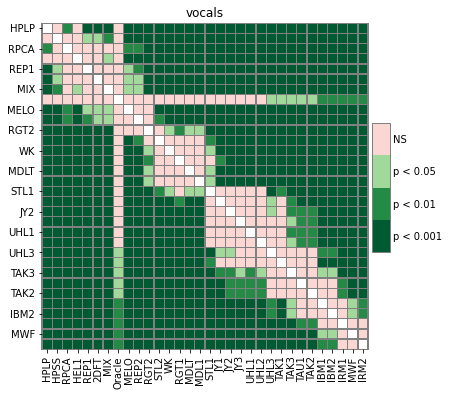

In [0]:
# resort them by median SDR
# Get sorting keys (sorted by median of SDR:vocals score)

target = 'vocals'
df_voc = df[(df.target == target) & (df.metric == "SDR")].copy()

targets_by_voc_sdr = df_voc.score.groupby(
    df_voc.method
).median().sort_values().index.tolist()

# get the two sortings
df_voc['method'] = df_voc['method'].astype(pd.api.types.CategoricalDtype(categories=targets_by_voc_sdr, ordered=True))

# # prepare the pairwise plots
pc_voc = sp.posthoc_conover(df_voc, val_col='score', group_col='method', sort=True)

f_voc = plt.figure(figsize=(6, 6))
# Format: diagonal, non-significant, p<0.001, p<0.01, p<0.05
heatmap_args = {'linewidths': 0.25, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.90, 0.35, 0.04, 0.3]}
ax, cb = sp.sign_plot(pc_voc, **heatmap_args)
ax.set_title(target)